In [102]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import astropy
import scipy.interpolate as interp
from astropy.io import fits

from EightBitTransit.cTransitingImage import TransitingImage
from EightBitTransit.inversion import *
from EightBitTransit.misc import *

%matplotlib inline

In [143]:
# extract a known planet from a simulated light curve!
times = np.linspace(-35.,35.,500)
planet_lowres_SItitle = TransitingImage(imfile="large_planet.png",
                                    lowres=100,
                                    lowrestype="mean", # Calculate the lower-resolution version of the image by averaging "neighborhoods" of pixels in the high-res image.
                                    lowresround=False, # Let the resulting low-res pixel values take on intermediate values between 0 and 1, i.e. don't round them to 0 or 1.
                                    v=0.4,
                                    t_ref=0.,
                                    t_arr=times)
#lowres_SItitle.plot_grid()
#print np.shape(lowres_SItitle.opacitymat)
    
planet_lowres_SItitle_LC, overlapTimes = planet_lowres_SItitle.gen_LC(t_arr=times) 
    
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax = plt.axes()
ax.plot(overlapTimes,planet_lowres_SItitle_LC,color="#1969ea",ls="-",lw=5)
ax.set_ylim(0.0,1.2)
plt.xlabel("Time [days]",fontsize=14)
plt.ylabel("Relative flux",fontsize=14)
plt.title(r"The low-res image's light curve as it transits left-to-right across the star at $v = 0.4 d^{-1}$",fontsize=16)
ax1 = plt.axes([.095, .2, 0.3, 0.3])
ax1.imshow(planet_lowres_SItitle.opacitymat,cmap="Greys",aspect="equal",origin="upper",interpolation='none',vmin=0.,vmax=1.)
#filename = "/Users/piperfrances/BSRC/code/results_subtract_artifacts/1"
#plt.savefig(filename, fmt="png")
plt.show()
plt.close()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':


IOError: [Errno 2] No such file or directory: 'ref_planet.png'

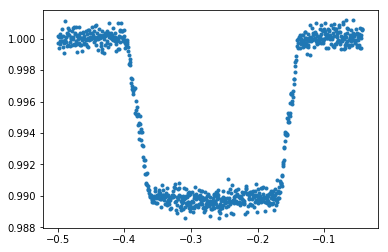

In [147]:
# hdul = fits.open('reference_planet_WASP126.fits')

# time = hdul[1].data['TIME']
# truth_LC = hdul[1].data['FLUX']
# LC_err = hdul[1].data['FLUX_ERR']

# LC = hdul[1].data['FLUX'][:800]
# time = hdul[1].data['TIME'][:800]

# plt.plot(time, LC, '.')

hdul = fits.open('large_planet.fits')

time = hdul[1].data['TIME']
truth_LC = hdul[1].data['FLUX']
#LC_err = hdul[1].data['FLUX_ERR']
LC_err = truth_LC_err = np.linspace(0, 0, truth_LC.size)

LC = hdul[1].data['FLUX'][:800]
times = hdul[1].data['TIME'][:800]

plt.plot(time, LC, '.')

In [126]:
# truth_LC = planet_noisy_LC
# times = time-time[400]
# truth_LC_err = np.linspace(0, 0, truth_LC.size)

In [148]:
# Hcode/, we present an inversion of Dip 5 of Boyajian's Star, by all four of the available inversion algorithm.
# This code reproduces figure 12 of Sandford et al. 2018.

# Limb-darkening coefficients interpolated from Sing (2010):
LDlaw="quadratic"
LDCs = [0.1, 0.1] #waiting for Ann Marie to let me know



# data = np.genfromtxt("./boyajian_dip5_data.csv",delimiter=",")

# times = data[:,0]
# truth_LC = data[:,1]
# truth_LC_err = data[:,2]

v = 0.4


ValueError: Big-endian buffer not supported on little-endian compiler

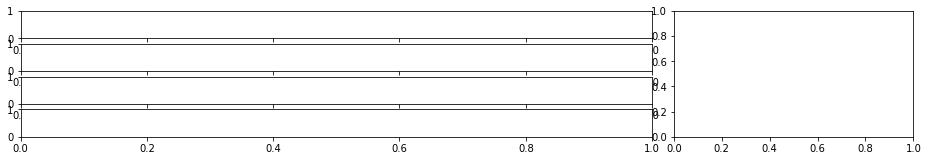

In [149]:
test_vs = np.array((0.4,0.8,1.6,3.2))

ref = np.int(np.ceil((times.size/2)))

t_ref=3

path = "/mnt_home/pstacey/py2/BSRC/code/huger_ref_planet_LC_to_MGSTRCT"

fig = plt.figure(figsize=(16,3*len(test_vs)))
gs = gridspec.GridSpec(len(test_vs)*5, 7)

maxmax=0.

for i in range(0, len(test_vs)):
    v = test_vs[i]
    print "v = {0}".format(v)
    
    # N chosen to be the highest possible integer value at each v, given that M is calculated from v (see below)
    # and that N * M cannot exceed the number of observed data points.
    if v < 1.0:
        N = 10
    elif v < 2.0:
        N = 7
    else:
        N = 5
    
    w = 2./N
    M = int(np.ceil((2.*(t_ref - np.min(times))*v - 2.)/w))
    #M = int(np.ceil(N/2))
    
    
    ti = TransitingImage(opacitymat=np.zeros((N,M)), LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=times)
    trial_LC, overlapTimes = ti.gen_LC(times)
    
    tMin = t_ref - (2. + ti.w*M)/(2.*v)
    tMax = t_ref + (2. + ti.w*M)/(2.*v)
    overlappingTimesMask = (times > tMin) & (times < tMax)
        
    overlappingObsLC = truth_LC[overlappingTimesMask]
    overlappingObsLCerr = truth_LC_err[overlappingTimesMask]
    
    # Since the light blocked by each pixel at each time step does not depend on the pixel's opacity, we can calculate it in advance to save time.
    try:
        LCdecs = np.load(path+"_LCdecs_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        LCdecs = calculateLCdecrements(N=N,M=M,LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, times=overlapTimes)
        np.save(path+"_LCdecs_v{0}_N{1}_M{2}.npy".format(v, N, M), LCdecs)
   
    arcAvg_ax = plt.subplot(gs[5*i, 0:5])
    SART_ax = plt.subplot(gs[5*i+1, 0:5])
    pars_ax = plt.subplot(gs[5*i+2, 0:5])
    comb_ax = plt.subplot(gs[5*i+3, 0:5])
    
    LC_ax = plt.subplot(gs[5*i:5*i+4, 5:])
    
    #Arc-averaging
    try: 
        arcAvg = np.load(path+"_arcAvg_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        avgBasis = makeArcBasisAverage(N=N, M=M, t_ref=t_ref, v=v, LDlaw=LDlaw, LDCs=LDCs, times=overlapTimes, LCdecrements=LCdecs, obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr)
        arcAvg = np.mean(avgBasis,axis=0)
        np.save(path+"_arcAvg_v{0}_N{1}_M{2}.npy".format(v, N, M), arcAvg)

    arcAvg = arcAvg.reshape(N,M)
    arcAvg = ((arcAvg + arcAvg[::-1,:])/2.)
    
    arcAvg_ti = TransitingImage(opacitymat=arcAvg, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    arcAvg_LC, overlapTimes = arcAvg_ti.gen_LC(overlapTimes)
    
    arcAvg = renormBasis(arcAvg,arcAvg_LC,truth_LC)
    arcAvg_ti = TransitingImage(opacitymat=arcAvg, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    arcAvg_LC, overlapTimes = arcAvg_ti.gen_LC(overlapTimes)
    
    if np.max(arcAvg) > maxmax:
        maxmax = np.max(arcAvg)
        
        
    # arc combinatorics
    try:
        comb = np.load(path+"_arcCombinatorics_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        combBasis = makeArcBasisCombinatoric(N=N, M=M, t_ref=t_ref, v=v, LDlaw=LDlaw, LDCs=LDCs, times=overlapTimes, LCdecrements=LCdecs, obsLC=overlappingObsLC, obsLCerr=overlappingObsLCerr)
        comb = np.mean(combBasis,axis=0)
        np.save(path+"_arcCombinatorics_v{0}_N{1}_M{2}.npy".format(v, N, M), comb)
    
    comb = comb.reshape(N,M)
    comb = ((comb + comb[::-1,:])/2.)
    
    comb_ti = TransitingImage(opacitymat=comb, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    comb_LC, overlapTimes = comb_ti.gen_LC(overlapTimes)
    
    comb = renormBasis(comb,comb_LC,truth_LC)
    comb_ti = TransitingImage(opacitymat=comb, LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, t_arr=overlapTimes)
    comb_LC, overlapTimes = comb_ti.gen_LC(overlapTimes)
    
    arcAvgImg = arcAvg_ax.imshow(arcAvg, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    
    parsImg = pars_ax.imshow(pars, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    
    LC_ax.plot(overlapTimes-t_ref, overlappingObsLC,'k-',lw=3,label='Truth')
    LC_ax.plot(overlapTimes-t_ref, arcAvg_LC,ls='-',lw=1.5,color='#F90000',label='Arc-averaging')
    LC_ax.plot(overlapTimes-t_ref, comb_LC,ls='-',lw=1.5,color='#FCBF49',label='Arc combinatorics')
    LC_ax.set_ylim(np.min(truth_LC)-0.01,1.01)
    LC_ax.set_xlim(-4.85-t_ref, 6.01)
    
    arcAvg_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#F90000',ms=15, clip_on=False)
    comb_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#FCBF49',ms=15, clip_on=False)
    
    for ax in [arcAvg_ax, comb_ax]:
        ax.set_xlim(-0.5,M-0.5)
        ax.set_ylim(-0.5,N-0.5)
        ax.set_xticks([])
        ax.set_yticks([])
        
    LC_ax.set_xticks(np.arange(-6,7,2))
    LC_ax.set_yticks(np.arange(0.85,1.01,0.05))  
    LC_ax.set_xticklabels([])
    LC_ax.set_yticklabels([])  
    LC_ax.yaxis.tick_right()
    
plt.show()
    
    

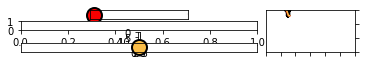

In [78]:
plt.clf()
arcAvg_ax = plt.subplot(gs[5*i, 0:5])
SART_ax = plt.subplot(gs[5*i+1, 0:5])
pars_ax = plt.subplot(gs[5*i+2, 0:5])
comb_ax = plt.subplot(gs[5*i+3, 0:5])
    
LC_ax = plt.subplot(gs[5*i:5*i+4, 5:])

arcAvgImg = arcAvg_ax.imshow(arcAvg, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)

parsImg = pars_ax.imshow(pars, cmap='Greys', interpolation='nearest',vmin=0.,vmax=maxmax)
    
LC_ax.plot(overlapTimes-t_ref, overlappingObsLC,'k-',lw=3,label='Truth')
LC_ax.plot(overlapTimes-t_ref, arcAvg_LC,ls='-',lw=1.5,color='#F90000',label='Arc-averaging')
LC_ax.plot(overlapTimes-t_ref, comb_LC,ls='-',lw=1.5,color='#FCBF49',label='Arc combinatorics')
#LC_ax.set_ylim(np.min(truth_LC)-0.01,1.01)
#LC_ax.set_xlim(-4.85-t_ref, 6.01)
    
arcAvg_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#F90000',ms=15, clip_on=False)
comb_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#FCBF49',ms=15, clip_on=False)
    
for ax in [arcAvg_ax, comb_ax]:
#     ax.set_xlim(-0.5,M-0.5)
#     ax.set_ylim(-0.5,N-0.5)
    ax.set_xticks([])
    ax.set_yticks([])
        
LC_ax.set_xticks(np.arange(-6,7,2))
LC_ax.set_yticks(np.arange(0.85,1.01,0.05))  
LC_ax.set_xticklabels([])
LC_ax.set_yticklabels([])  
LC_ax.yaxis.tick_right()

plt.show()

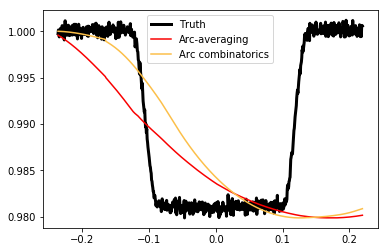

In [80]:
plt.plot(overlapTimes-times[ref], overlappingObsLC,'k-',lw=3,label='Truth')
plt.plot(overlapTimes-times[ref], arcAvg_LC,ls='-',lw=1.5,color='#F90000',label='Arc-averaging')
plt.plot(overlapTimes-times[ref], comb_LC,ls='-',lw=1.5,color='#FCBF49',label='Arc combinatorics')
plt.legend()
plt.show()

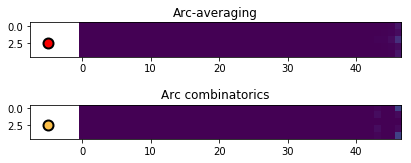

In [101]:
plt.clf()
plt.figure(figsize=(30, 15))
arcAvg_ax = plt.subplot(gs[5*i, 0:5])
comb_ax = plt.subplot(gs[5*i+2, 0:5])

arcAvgImg = arcAvg_ax.imshow(arcAvg, interpolation='nearest',vmin=0.,vmax=maxmax)
arcAvg_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#F90000',ms=10, clip_on=False)
arcAvg_ax.set_title("Arc-averaging")

combImg = comb_ax.imshow(comb, interpolation='nearest',vmin=0.,vmax=maxmax)
comb_ax.plot(np.array((-5)), np.array((N/2.)), marker='o',mec='k',mew=2,color='#FCBF49',ms=10, clip_on=False)
comb_ax.set_title("Arc combinatorics")
plt.show()

In [115]:
len(overlappingTimesMask)

500

In [116]:
len(truth_LC)

800

In [123]:
len(times)

500

In [129]:
M

-9

In [150]:
pwd

u'/mnt_home/pstacey/py2/BSRC/code'